# <div align="center" style="color: #ff5733;">Line 77 to 82 Code</div>

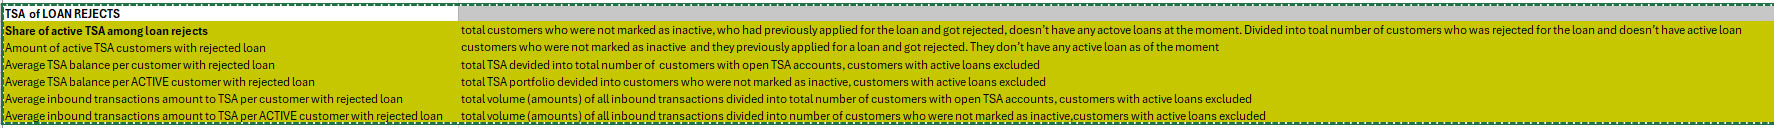

In [1]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.

# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')

# %% [markdown]
## Configure Settings
# Set options or configurations as needed
# Example: pd.set_option('display.max_columns', None)

In [2]:
sq = """WITH
  custrejectlist --- List of all customer id where were ever rejected
  AS (
  SELECT
    customerId,
    digitalLoanAccountId,
    startApplyDateTime,
    applicationStatus
  FROM
    `risk_credit_mis.loan_master_table`
  WHERE
    applicationStatus LIKE 'REJECT' ),
  Activecustlist ---- List of customer id with active loan
  AS (
  SELECT
    customerId,
    digitalLoanAccountId,
    loanPaidStatus
  FROM
    `risk_credit_mis.loan_master_table`
  WHERE
    COALESCE(loanPaidStatus, 'NA') IN ('Normal',
      'In Arrears') ),
  RejectcustwithnoActiveLoan --- List of customer id who have a rejected loan earlier and no active current loan
  AS (
  SELECT
    customerId,
    max(digitalLoanAccountId) maxloanid,
    max(startApplyDateTime) maxapplicationdate,
    max(applicationStatus) applicationstatus
  FROM
    custrejectlist
  WHERE
    customerId NOT IN (
    SELECT
      customerId
    FROM
      Activecustlist) group by 1),
  W_DT1 AS (
  SELECT
    DT
  FROM
    UNNEST( GENERATE_DATE_ARRAY('2020-11-25', CURRENT_DATE - 1, INTERVAL 1 DAY) ) AS DT ),
  W_DT2 AS (
  SELECT
    A.*,
    (
    SELECT
      MAX(DT)
    FROM
      prj-prod-dataplatform.dap_ds_poweruser_playground.php_to_usd B
    WHERE
      B.DT <= A.DT) AS MAXDT
  FROM  
    W_DT1 A ),
  TSA_Customer as
(SELECT distinct wd.DT, 
cb.client_id, 
cb.account_type, 
cb.clearedbalance, 
case when cast(cb.client_id as int64) in (select customerId from RejectcustwithnoActiveLoan) then cb.client_id end RejectcustwithnoActiveLoan
FROM W_DT1 wd
Left join `prj-prod-dataplatform.risk_mart.customer_balance` cb on cb.balanceDateAsOf = wd.DT
WHERE cb.account_type like 'Tonik Account'
)
select DT, account_type, count(distinct client_id) TSA_Accounts, sum(clearedbalance) totalbalance 
, count(distinct RejectcustwithnoActiveLoan) TSAAccountwithrejectedloanandnoactiveloan
, sum(case when RejectcustwithnoActiveLoan is not null then clearedbalance else 0 end) balanceoftsaaccountwithrejectloannotactiveloan
from TSA_Customer 
group by 1,2
order by 1 desc ;"""

In [3]:
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
df.shape

Job ID 434c75f7-33c8-4c18-a85b-7e5a1e795ea6 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


(779, 6)

In [4]:
df.head()

,DT,account_type,TSA_Accounts,totalbalance,TSAAccountwithrejectedloanandnoactiveloan,balanceoftsaaccountwithrejectloannotactiveloan
0,2024-04-10,Tonik Account,530509,4.633592e+08,68898,3401808.24
1,2024-04-09,Tonik Account,529973,4.586662e+08,68655,3485085.90
2,2024-04-08,Tonik Account,533568,4.574377e+08,68415,3688823.02
3,2024-04-07,Tonik Account,533025,4.591930e+08,68176,3509070.04
4,2024-04-06,Tonik Account,532367,4.640021e+08,67917,3713726.45
